In [1]:
import cv2

In [2]:
import matplotlib.pyplot as plt
import os
print(os.getcwd())
os.listdir(os.getcwd())

C:\Users\ShahMuhamad\Desktop\NEW_OSL


['.ipynb_checkpoints',
 'database',
 'Face-Recognition-Final - Copy.ipynb',
 'Face-Recognition-Final.ipynb',
 'haarcascades',
 'images',
 'models',
 'saved_image',
 'utils_and_webcam',
 '__pycache__']

In [ ]:
!aws s3 sync s3://sagemaker-studio-XXX-mz9wugir6l/Testing-trump.jpg /home/ec2-user/SageMaker/Pics/

In [ ]:
# print(os.path.join(path, "User/Desktop", "file.txt")) 
#print(os.listdir("/home/ec2-user/SageMaker/Pics"))

In [ ]:
plt.imshow(cv2.imread("Testing-trump1.jpg"))
plt.show()

In [2]:
# !pip install keras
# !pip install tensorflow
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
# from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
# from keras.engine.topology import Layer
from tensorflow.keras.layers import Layer, InputSpec
from keras import backend as K
from keras.models import load_model
K.set_image_data_format('channels_first')

import pickle
import cv2
import os.path
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
# from utility import *
from utils_and_webcam.utility import *
# from webcam_utility import *
from utils_and_webcam.webcam_utility import *

# Libs Installed

In [3]:
# triplet loss function
#  y_pred - list containing three objects:
#         anchor(None, 128) -- encodings for the anchor images
#         positive(None, 128) -- encodings for the positive images
#         negative(None, 128) -- encodings for the negative images
def triplet_loss(y_true, y_pred, alpha = 0.2):
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    print("This is a custom loss function")
    print("y_list:",y_pred)
    
    # triplet formula components
    pos_dist = tf.reduce_sum( tf.square(tf.subtract(y_pred[0], y_pred[1])) )
    neg_dist = tf.reduce_sum( tf.square(tf.subtract(y_pred[0], y_pred[2])) )
    basic_loss = pos_dist - neg_dist + alpha
    
    loss = tf.maximum(basic_loss, 0.0)
   
    return loss

In [4]:
# load the model
FRmodel = load_model('models/facenet_keras.h5', custom_objects={'triplet_loss': triplet_loss})
# FRmodel = load_model('models/facenet_keras.h5', compile=False)
FRmodel.compile(loss=triplet_loss)

In [5]:
# initialize the user database
def ini_user_database():
    # check for existing database
    if os.path.exists('database/user_dict.pickle'):
        with open('database/user_dict.pickle', 'rb') as handle:
            user_db = pickle.load(handle)   
    else:
        # make a new one
        # we use a dict for keeping track of mapping of each person with his/her face encoding
        user_db = {}
        # create the directory for saving the db pickle file
        os.makedirs('database')
        with open('database/user_dict.pickle', 'wb') as handle:
            pickle.dump(user_db, handle, protocol=pickle.HIGHEST_PROTOCOL)   
    return user_db

In [6]:
# adds a new user face to the database using his/her image stored on disk using the image path
def add_user_img_path(user_db, FRmodel, name, img_path):
    if name not in user_db: 
        user_db[name] = img_to_encoding(img_path, FRmodel)
        print("Encodings:",user_db[name])
        # save the database
        with open('database/user_dict.pickle', 'wb') as handle:
                pickle.dump(user_db, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print('User ' + name + ' added successfully')
    else:
        print('The name is already registered! Try a different name.........')

In [7]:
# adds a new user using image taken from webcam
def add_user_webcam(user_db, FRmodel, name):
    # we can use the webcam to capture the user image then get it recognized
    face_found = detect_face(user_db, FRmodel)

    if face_found:
        img_loc="saved_image/UserGenerated.jpg"
        resize_img(img_loc,(96,96))
        
        if name not in user_db: 
            add_user_img_path(user_db, FRmodel, name, "saved_image/UserGenerated.jpg")
        else:
            print('The name is already registered! Try a different name.........')
    else:
        print('There was no face found in the visible frame. Try again...........')

In [8]:
# deletes a registered user from database
def delete_user(user_db, name):
    popped = user_db.pop(name, None)
    
    if popped is not None:
        print('User ' + name + ' deleted successfully')
        # save the database
        with open('database/user_dict.pickle', 'wb') as handle:
                pickle.dump(user_db, handle, protocol=pickle.HIGHEST_PROTOCOL)
    elif popped == None:
        print('No such user !!')

In [9]:
# we use a dict for keeping track of mapping of each person with his/her face encoding
user_db = ini_user_database()

In [10]:
# add a user
add_user_img_path(user_db, FRmodel, "chris", "images/Chris.jpg")

The name is already registered! Try a different name.........


In [11]:
add_user_webcam(user_db, FRmodel, "Muhammad")

The name is already registered! Try a different name.........


In [ ]:
delete_user(user_db, "Muhammad")

In [33]:
# recognize the input user face encoding by checking for it in the database
def find_face(image_path, database, model, threshold = 0.6):
    # find the face encodings for the input image
    encoding = img_to_encoding(image_path, model)
    
    min_dist = 99999
    # loop over all the recorded encodings in database 
    for name in database:
        # find the similarity between the input encodings and claimed person's encodings using L2 norm
        dist = np.linalg.norm(np.subtract(database[name], encoding) )
        # check if minimum distance or not
        if dist < min_dist:
            min_dist = dist
            identity = name

    if min_dist > threshold:
        print("Distance = ", min_dist)
        print("User not in the database.")
        identity = 'Unknown Person'
    else:
        print ("Hi! " + str(identity) + ", L2 distance: " + str(min_dist) , "Threshold: "+ str(threshold))
        
    return min_dist, identity

In [38]:
# takes an input image from webcam and performs face recognition on it
def do_face_recognition_webcam(user_db, FRmodel, threshold = 0.7):
    # we can use the webcam to capture the user image then get it recognized
    face_found = detect_face(user_db, FRmodel)

    if face_found:
        # img_loc= location where the temporary webcam images are saved
        # resize the image for the model
        img_loc="saved_image/UserGenerated.jpg"
        resize_img(img_loc,(96,96))
        find_face(img_loc, user_db, FRmodel, threshold)
    else:
        print('There was no face found in the visible frame. Try again...........')

In [39]:
# takes an input image and performs face recognition on it
def do_face_recognition_from_image(user_db, FRmodel, threshold = 0.7, img_loc = "saved_image/UserGenerated.jpg"):
    # resize the image
    img = cv2.imread(img_loc, 1)
    img = cv2.resize(img, (96, 96))
    # save the temporary image
    cv2.imwrite("saved_image/UserGenerated.jpg", img)

    find_face("saved_image/UserGenerated.jpg", user_db, FRmodel, threshold)

In [37]:
# Using webcam
do_face_recognition_webcam(user_db, FRmodel, 0.7)
# do_face_recognition_webcam(user_db, FRmodel, 10)

original: (160, 160, 3)
Distance =  3.5329962
User not in the database.


In [40]:
add_user_img_path(user_db, FRmodel, "david", "images/David.jpg")
add_user_img_path(user_db, FRmodel, "trump", "images/Trump.jpg")

The name is already registered! Try a different name.........
The name is already registered! Try a different name.........


In [63]:
# # recognize the input user face encoding by checking for it in the database
def find_face(image_path, database, model, threshold = 0.6):
    # find the face encodings for the input image
    print(image_path)
    encoding = img_to_encoding(image_path, model)
    
    min_dist = 99999
    # loop over all the recorded encodings in database 
    for name in database:
        # find the similarity between the input encodings and claimed person's encodings using L2 norm
        dist = np.linalg.norm(np.subtract(database[name], encoding) )
        # check if minimum distance or not
        if dist < min_dist:
            min_dist = dist
            identity = name
    print("min_dist:",min_dist," and Identity:",identity, "threshold: ",threshold)
    if min_dist < threshold: #condition reversed
        print("User not in the database.")
        identity = 'Unknown Person'
    else:
        print ("Hi! " + str(identity) + ", L2 distance: " + str(min_dist))
        
    return min_dist, identity

In [64]:
# # takes an input image from webcam and performs face recognition on it
def do_face_recognition_webcam(user_db, FRmodel, threshold = 0.7):
    # we can use the webcam to capture the user image then get it recognized
    face_found = detect_face(user_db, FRmodel)

    if face_found:
        # "saved_image/1.jpg": location where the temporary webcam images are saved
        # resize the image for the model
        resize_img("saved_image/UserGenerated.jpg")
        find_face(img_loc, user_db, FRmodel, threshold)
    else:
        print('There was no face found in the visible frame. Try again...........')

In [65]:
# # takes an input image and performs face recognition on it
def do_face_recognition_from_image(user_db, FRmodel, threshold = 0.7, img_loc = "saved_image/UserGenerated.jpg"):
    # resize the image
    img = cv2.imread(img_loc, 1)
    img = cv2.resize(img, (96, 96))
    # save the temporary image
    cv2.imwrite("saved_image/UserGenerated.jpg", img)

    find_face("saved_image/UserGenerated.jpg", user_db, FRmodel, threshold)
    

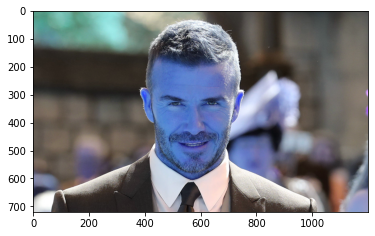

saved_image/UserGenerated.jpg
original: (96, 96, 3)
min_dist: 6.5260267  and Identity: david threshold:  0.7
Hi! david, L2 distance: 6.5260267


In [72]:
# using image on disk
import matplotlib.pyplot as plt
plt.imshow(cv2.imread("David-Test.jpg"))
plt.show()
do_face_recognition_from_image(user_db, FRmodel, threshold = 0.7, img_loc = "David-Test.jpg")

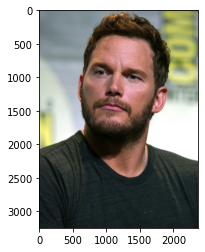

saved_image/UserGenerated.jpg
original: (96, 96, 3)
min_dist: 10.878368  and Identity: chris threshold:  0.7
Hi! chris, L2 distance: 10.878368


In [67]:
# using image on disk
plt.imshow(cv2.cvtColor(cv2.imread("Chris_Test.jpg"), cv2.COLOR_RGB2BGR))
plt.show()
do_face_recognition_from_image(user_db, FRmodel, threshold = 0.7, img_loc = "Chris_Test.jpg")

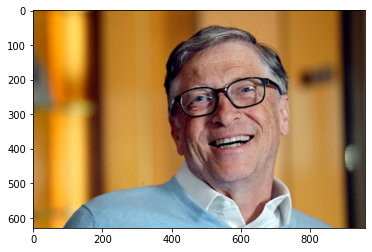

saved_image/UserGenerated.jpg
original: (96, 96, 3)
min_dist: 4.4945946  and Identity: david threshold:  0.7
Hi! david, L2 distance: 4.4945946


In [68]:
# using image on disk
plt.imshow(cv2.cvtColor(cv2.imread("Bill-Test.jpg"), cv2.COLOR_RGB2BGR))
plt.show()
do_face_recognition_from_image(user_db, FRmodel, threshold = 0.7, img_loc = "Bill-Test.jpg")

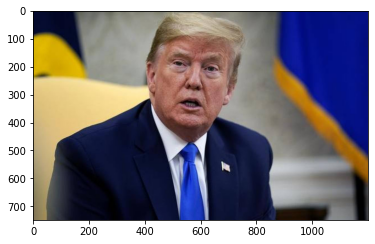

saved_image/UserGenerated.jpg
original: (96, 96, 3)
min_dist: 10.430048  and Identity: trump threshold:  0.7
Hi! trump, L2 distance: 10.430048


In [69]:
# using image on disk
plt.imshow(cv2.cvtColor(cv2.imread("Testing-trump1.jpg"), cv2.COLOR_RGB2BGR))
plt.show()
do_face_recognition_from_image(user_db, FRmodel, threshold = 0.7, img_loc = "Testing-trump1.jpg")

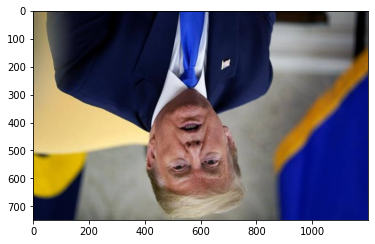

saved_image/UserGenerated.jpg
original: (96, 96, 3)
min_dist: 7.9695005  and Identity: trump threshold:  0.7
Hi! trump, L2 distance: 7.9695005


In [70]:
# using image on disk
plt.imshow(cv2.cvtColor(cv2.imread("Testing-trump1-Inverted.jpg"), cv2.COLOR_RGB2BGR))
plt.show()
do_face_recognition_from_image(user_db, FRmodel, threshold = 0.7, img_loc = "Testing-trump1-Inverted.jpg")

# Thank you